In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
def read_train_val(directory):
  train_val=pd.read_csv(directory)
  return train_val


directory='/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project1/train-val.csv'
train_val=read_train_val(directory)

In [ ]:
def read_test(directory):
  test=pd.read_csv(directory)
  return test

directory='/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project1/test.csv'
test_set=read_test(directory)

# Exploratory Data **Analysis**

Τα δείγματα είναι τόσα όσες και οι γραμμές του train_val ενώ τα χαρακτηριστικά είναι όσες οι στήλες του train_val μείον 1 καθώς το RainTomorrow είναι το target value.

In [ ]:

num_samples=len(train_val) #Αριθμός Δειγμάτων
num_features=len(train_val.columns)-1 #Αριθμός Χαρακτηριστικών

print(f'Ο αριθμός των δειγμάτων είναι: {num_samples}')
print(f'Ο αριθμός των χαρακτηριστικών: {num_features}')


Ο αριθμός των δειγμάτων είναι: 48423
Ο αριθμός των χαρακτηριστικών: 23


 Παρατηρούμε πως τα περισσότερα χαρακτηριστικα είναι αριθμητικά παρ'όλα αυτά έχουμε και 5 κατηγορικά.

In [ ]:
train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48423 entries, 0 to 48422
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             48423 non-null  int64  
 1   Date           48423 non-null  object 
 2   Location       48423 non-null  object 
 3   MinTemp        48263 non-null  float64
 4   MaxTemp        48322 non-null  float64
 5   Rainfall       48423 non-null  float64
 6   Evaporation    28039 non-null  float64
 7   Sunshine       25426 non-null  float64
 8   WindGustDir    45302 non-null  object 
 9   WindGustSpeed  45330 non-null  float64
 10  WindDir9am     44602 non-null  object 
 11  WindDir3pm     47095 non-null  object 
 12  WindSpeed9am   48066 non-null  float64
 13  WindSpeed3pm   47566 non-null  float64
 14  Humidity9am    47865 non-null  float64
 15  Humidity3pm    47164 non-null  float64
 16  Pressure9am    43643 non-null  float64
 17  Pressure3pm    43634 non-null  float64
 18  Cloud9

In [ ]:
features_names=[i for i in train_val.columns[:-1]]

print('Τα ονόματα των χαρακτηριστικών είναι:', features_names)

Τα ονόματα των χαρακτηριστικών είναι: ['id', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


 Για το πλήθος των κλάσεων αρκεί να δούμε πόσες διαφορετικές τιμές παίρνει η
  η στήλη RainTomorrow

In [ ]:
num_classes=train_val['RainTomorrow'].nunique()

print(f'Ο αριθμός των κλάσεων είναι {num_classes}')

Ο αριθμός των κλάσεων είναι 2



**C1** = { Θα βρέξει αύριο },
**C0**= { Δεν θα βρέξει αύριο }

Για να βρούμε το cardinality της **C1** αρκεί να προσθέσουμε όλες τις τιμές της στήλης Rain_Tomorrow, καθως όποιο δείγμα ανήκει στην **C1** έχει label ίσο με 1 ενώ όποιο ανήκει στην **C0** με 0. Για το cardinality της **C0** αφαιρούμε αυτό που βρήκαμε από τον αριθμό των δειγμάτων.

In [ ]:
num_class_rain=int(sum(train_val['RainTomorrow']))
num_class_norain=num_samples-num_class_rain

print(f'Ο αριθμός των δειγμάτων που ανήκουν στην κλάση C1 είναι : {num_class_rain}')
print(f'Ο αριθμός των δειγμάτων που ανήκουν στην κλάση C0 είναι : {num_class_norain}')

Ο αριθμός των δειγμάτων που ανήκουν στην κλάση C1 είναι : 11059
Ο αριθμός των δειγμάτων που ανήκουν στην κλάση C0 είναι : 37364


 Για να εξετάσουμε τη συσχέτιση μεταξύ των αριθμητικών μας χαρακτηριστικών τυπώνουμε το correlation matrix καθώς και σχεδιάζουμε ενα heatmap του correlation για να εντοπίζουμε πιο εύκολα τα χαρακτηριστικά που έχουν μεγάλη συσχέτιση μεταξύ τους.

In [ ]:
correlation=train_val.corr(numeric_only=True)
correlation

,id,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
id,1.000000,0.104771,0.136331,-0.024047,0.096221,0.078911,0.047488,0.062482,0.040819,-0.129400,-0.085483,-0.104157,-0.108251,-0.073085,-0.066481,0.139226,0.120342,-0.003840,-0.002691
MinTemp,0.104771,1.000000,0.715692,0.096510,0.457483,0.053477,0.163349,0.193476,0.183079,-0.232420,0.021193,-0.372295,-0.385832,0.071455,0.006876,0.892621,0.682041,0.065077,0.084001
MaxTemp,0.136331,0.715692,1.000000,-0.103864,0.586798,0.469859,0.013580,0.003229,0.054409,-0.485241,-0.504320,-0.224734,-0.331614,-0.304386,-0.305659,0.881130,0.984609,-0.247060,-0.177480
Rainfall,-0.024047,0.096510,-0.103864,1.000000,-0.069284,-0.210261,0.160382,0.102262,0.068231,0.217506,0.258283,-0.178761,-0.125762,0.202290,0.162473,-0.007844,-0.108617,0.527639,0.244867
Evaporation,0.096221,0.457483,0.586798,-0.069284,1.000000,0.351482,0.194751,0.208774,0.154487,-0.521304,-0.392778,-0.226294,-0.261228,-0.188185,-0.193911,0.556079,0.569842,-0.191368,-0.122146
Sunshine,0.078911,0.053477,0.469859,-0.210261,0.351482,1.000000,-0.051283,-0.001514,0.055941,-0.471021,-0.634892,0.078309,0.010106,-0.693561,-0.708928,0.286368,0.492766,-0.314345,-0.437883
WindGustSpeed,0.047488,0.163349,0.013580,0.160382,0.194751,-0.051283,1.000000,0.633542,0.715518,-0.214060,0.004057,-0.485376,-0.434426,0.086327,0.125622,0.123985,-0.024427,0.188300,0.258618
WindSpeed9am,0.062482,0.193476,0.003229,0.102262,0.208774,-0.001514,0.633542,1.000000,0.541097,-0.289202,-0.019900,-0.266217,-0.212422,0.035081,0.066148,0.141875,-0.008063,0.121898,0.118477
WindSpeed3pm,0.040819,0.183079,0.054409,0.068231,0.154487,0.055941,0.715518,0.541097,1.000000,-0.166434,-0.003281,-0.327326,-0.289712,0.048956,0.032267,0.169477,0.030884,0.097368,0.109116
Humidity9am,-0.129400,-0.232420,-0.485241,0.217506,-0.521304,-0.471021,-0.214060,-0.289202,-0.166434,1.000000,0.644709,0.117477,0.167571,0.439629,0.349397,-0.472335,-0.478217,0.332583,0.244048


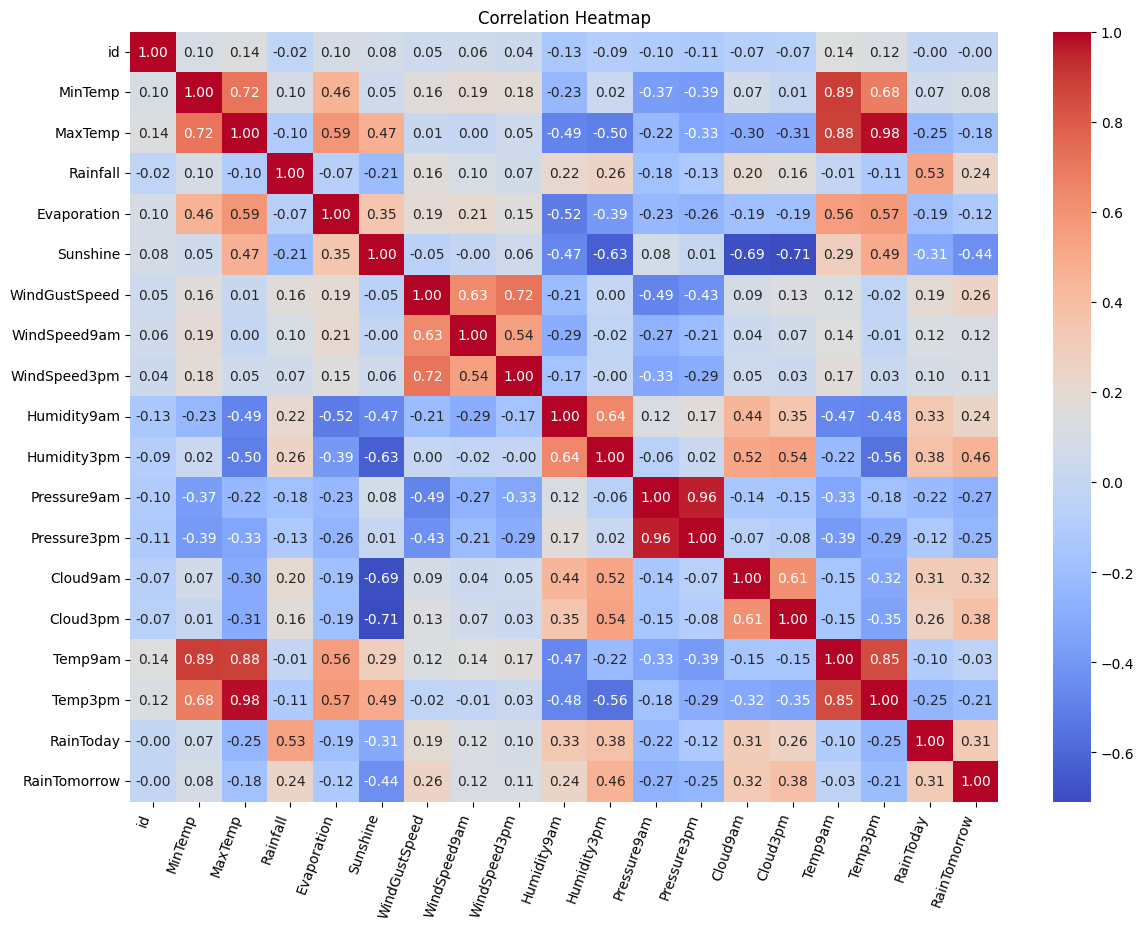

In [ ]:
%matplotlib inline
plt.figure(figsize=(14,10))
plt.title('Correlation Heatmap')
sns.heatmap(correlation, annot=True, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=70, ha='right')
plt.yticks()
plt.show()


Το παρακάτω κομμάτι κώδικα το χρησιμοποιώ για να βλέπω με πόσα άλλα χαρακτηριστικά συσχετίζεται πολύ (παραπάνω από το threshold που ορίζω) κάθε χαρακτηριστικό. Το χρησιμοποιώ γιατί το correlation heatmap είναι αρκετά clustered και μπορεί να ξεχαστεί κάτι.

In [ ]:
threshold=0.7
high_corr = (correlation.abs() > threshold).sum()
print(high_corr)

id               1
MinTemp          3
MaxTemp          4
Rainfall         1
Evaporation      1
Sunshine         2
WindGustSpeed    2
WindSpeed9am     1
WindSpeed3pm     2
Humidity9am      1
Humidity3pm      1
Pressure9am      2
Pressure3pm      2
Cloud9am         1
Cloud3pm         2
Temp9am          4
Temp3pm          3
RainToday        1
RainTomorrow     1
dtype: int64


Χρησιμοποιούμε αρχικά το Χ.describe για να δούμε μερικά περιγραφικά στατιστικά των χαρακτηριστικών μας όπως μέση τιμή, τυπική απόκλιση, τα 25% και 75% ποσοστημόρια κτλπ.

In [ ]:
train_val.describe()

,id,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,48423.000000,48263.000000,48322.000000,48423.000000,28039.000000,25426.000000,45330.000000,48066.000000,47566.000000,47865.000000,47164.000000,43643.000000,43634.000000,30533.000000,29442.000000,48197.000000,47510.000000,48423.000000,48423.000000
mean,24212.000000,10.661530,21.468416,2.218592,4.590831,7.162259,39.097948,13.670162,18.228167,70.574992,52.791621,1018.995010,1016.537425,4.407002,4.556076,15.411939,20.025576,0.231811,0.228383
std,13978.660379,6.058113,6.557396,7.377476,3.473241,3.607741,14.004819,8.957912,8.911087,18.817514,20.262837,7.030803,6.958443,2.892678,2.718374,6.119331,6.414521,0.421994,0.419795
min,1.000000,-8.200000,-3.200000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,982.000000,980.200000,0.000000,0.000000,-7.000000,-4.200000,0.000000,0.000000
25%,12106.500000,6.500000,16.700000,0.000000,2.200000,4.400000,30.000000,7.000000,11.000000,59.000000,39.000000,1014.500000,1011.900000,1.000000,2.000000,11.100000,15.400000,0.000000,0.000000
50%,24212.000000,10.300000,20.700000,0.000000,4.000000,8.000000,37.000000,13.000000,17.000000,72.000000,53.000000,1019.100000,1016.600000,5.000000,5.000000,14.900000,19.300000,0.000000,0.000000
75%,36317.500000,14.700000,25.800000,0.800000,6.200000,10.200000,46.000000,19.000000,24.000000,85.000000,66.000000,1023.700000,1021.200000,7.000000,7.000000,19.500000,24.200000,0.000000,0.000000
max,48423.000000,29.600000,45.400000,371.000000,68.800000,14.200000,126.000000,87.000000,83.000000,100.000000,100.000000,1040.900000,1039.600000,9.000000,8.000000,37.300000,43.300000,1.000000,1.000000


Επαναλαμβάνουμε την ίδια διαδικασία και για τα κατηγορικά χαρακτηριστικά μας.

In [ ]:
train_val.describe(include="object")

,Date,Location,WindGustDir,WindDir9am,WindDir3pm
count,48423,48423,45302,44602,47095
unique,2534,49,16,16,16
top,2013-05-21,Sydney,W,N,W
freq,34,1145,3586,4178,3607


Με τα παρακάτω ιστογράμματα κατανοώ περαιτέρω τις κατανομές των χαρακτηριστικών μου. Βλέπω επίσης πως υπάρχουν αρκετά outliers σε ορισμένα χαρακτηριστικα όπως WindSpeed9am, Humidity9am, Evaporation. Την ύπαρξη outliers θα την ελέγξω και παρακάτω.

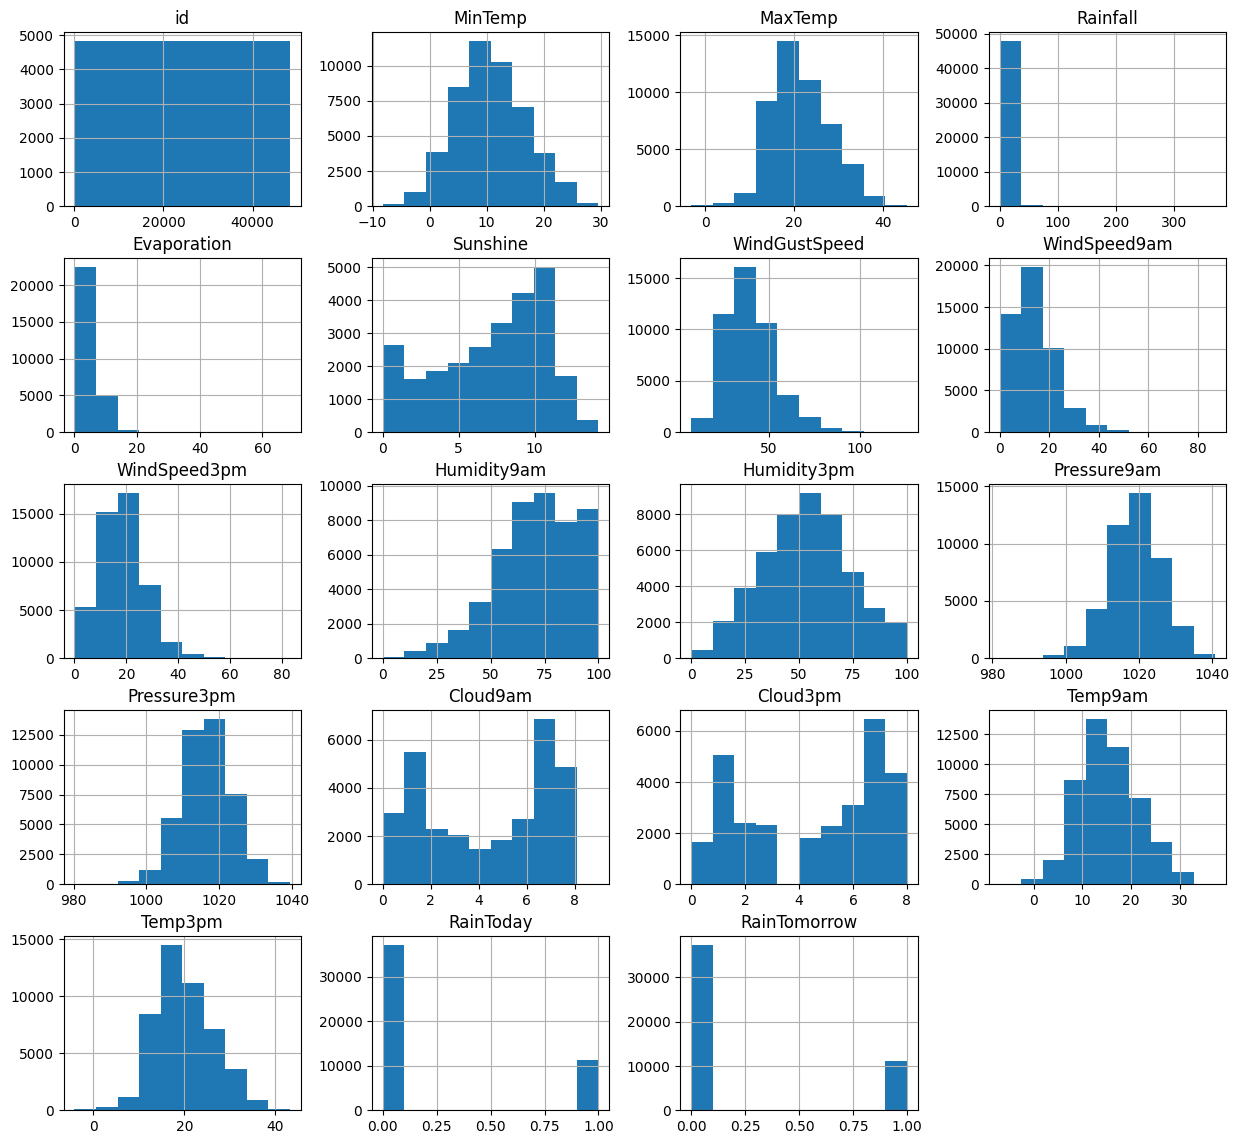

In [ ]:
train_val.hist(bins=10, figsize=(15, 14))
plt.show()

Eξετάζουμε και πόσα null-values έχουμε σε κάθε χαρακτηριστικό.

In [ ]:
print(train_val.isnull().sum())
print(train_val.isnull().mean())

id                   0
Date                 0
Location             0
MinTemp            160
MaxTemp            101
Rainfall             0
Evaporation      20384
Sunshine         22997
WindGustDir       3121
WindGustSpeed     3093
WindDir9am        3821
WindDir3pm        1328
WindSpeed9am       357
WindSpeed3pm       857
Humidity9am        558
Humidity3pm       1259
Pressure9am       4780
Pressure3pm       4789
Cloud9am         17890
Cloud3pm         18981
Temp9am            226
Temp3pm            913
RainToday            0
RainTomorrow         0
dtype: int64
id               0.000000
Date             0.000000
Location         0.000000
MinTemp          0.003304
MaxTemp          0.002086
Rainfall         0.000000
Evaporation      0.420957
Sunshine         0.474919
WindGustDir      0.064453
WindGustSpeed    0.063875
WindDir9am       0.078909
WindDir3pm       0.027425
WindSpeed9am     0.007373
WindSpeed3pm     0.017698
Humidity9am      0.011523
Humidity3pm      0.026000
Pressure9am      0.

Με το παρακάτω κομμάτι κώδικα βλέπουμε πόσα outliers έχουμε σε κάθε χαρακτηριστικό μας

In [ ]:
Q1 = train_val.quantile(0.25)
Q3 = train_val.quantile(0.75)
IQR = Q3 - Q1
outliers = ((train_val < (Q1 - 1.5 * IQR)) | (train_val > (Q3 + 1.5* IQR))).sum()

print(outliers)

Cloud3pm             0
Cloud9am             0
Date                 0
Evaporation        699
Humidity3pm          0
Humidity9am        499
Location             0
MaxTemp            351
MinTemp             78
Pressure3pm        415
Pressure9am        497
RainToday        11225
RainTomorrow     11059
Rainfall          8939
Sunshine             0
Temp3pm            409
Temp9am            154
WindDir3pm           0
WindDir9am           0
WindGustDir          0
WindGustSpeed     1327
WindSpeed3pm       438
WindSpeed9am       588
id                   0
dtype: int64


<ipython-input-20-6f83f27c9467>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = train_val.quantile(0.25)
<ipython-input-20-6f83f27c9467>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = train_val.quantile(0.75)
<ipython-input-20-6f83f27c9467>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((train_val < (Q1 - 1.5 * IQR)) | (train_val > (Q3 + 1.5* IQR))).sum()


# **Προεπεξεργασία** συνόλου δεδομένων





Αρχικά βάση της παραπάνω ανάλυσης παρ'όλο που παρατηρώ πολύ μεγάλο ποσοστό από null-values στα 'Sunshine', 'Evaporation', 'Cloud9am', 'Cloud3pm' μετά από trial and error θα κρατήσω μονο τα Sunshine και Cloud3pm γιατί με αυτά βλέπω καλύτερα αποτελέσματα. Αφαιρώ την στήλη id καθώς καθώς δεν βοηθάει στην συγκεκριμένη ανάλυση. Βάση του Correlation Heatmap παρατηρώ πως τα χαρακτηριστικά MinTemp,Evaporation,WindSpeed9am,WindSpeed3pm,Temp9am έχουν πολύ μικρό correlation με το RainTomorrow οπότε τα διώχνω. Με τα χαρακτηριστικά που μένουν, βλέπω πολύ μεγάλο correlation μεταξύ των MaxTemp & Temp3pm, Pressure9am & Pressure3pm οπότε από αυτά κρατάω μόνο τα Temp3pm και Pressure3pm. Επίσης προκειμένου να χρησιμοποιήσω το Date θα το μετατρέψω σε 3 στηλες 'Day' 'Month' 'Year' ώστε να μπορέσω να χειριστώ κάθε μια σαν αριθμητικό χαρακτηριστικό γιατί αν κάνω onehotencoding στο Date οι διαστάσεις ανεβαίνουν εκθετικά πολύ.

In [ ]:

train_val['Date'] = pd.to_datetime(train_val['Date'])


month = train_val['Date'].dt.month
day=train_val['Date'].dt.day
year=train_val['Date'].dt.year

train_val.drop('Date',axis=1,inplace=True)

train_val.insert(1,'Year',year)
train_val.insert(2,'Month',month)
train_val.insert(3,'Day',day)

In [ ]:
train_val.drop(['id','MinTemp','Evaporation','WindSpeed9am','WindSpeed3pm','Temp9am','MaxTemp','MaxTemp','Pressure9am','Cloud9am','WindDir9am','WindGustDir'],axis=1,inplace=True)


In [ ]:
train_val

,Year,Month,Day,Location,Rainfall,Sunshine,WindGustSpeed,WindDir3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud3pm,Temp3pm,RainToday,RainTomorrow
0,2009,3,4,Albury,0.2,NaN,57.0,WNW,57.0,26.0,1013.1,NaN,21.9,0.0,0.0
1,2009,3,5,Albury,0.0,NaN,50.0,W,60.0,33.0,1011.8,NaN,21.4,0.0,0.0
2,2009,3,9,Albury,0.0,NaN,24.0,NE,49.0,28.0,1015.9,NaN,30.5,0.0,0.0
3,2009,3,10,Albury,0.0,NaN,50.0,E,51.0,25.0,1016.2,NaN,30.8,0.0,1.0
4,2009,3,11,Albury,1.2,NaN,44.0,N,57.0,23.0,1018.0,NaN,29.6,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48418,2017,6,12,Uluru,0.0,NaN,46.0,E,56.0,29.0,1025.8,NaN,19.2,0.0,0.0
48419,2017,6,16,Uluru,0.0,NaN,24.0,E,53.0,24.0,1020.0,NaN,23.3,0.0,0.0
48420,2017,6,20,Uluru,0.0,NaN,31.0,E,59.0,27.0,1021.2,NaN,20.9,0.0,0.0
48421,2017,6,23,Uluru,0.0,NaN,37.0,WNW,53.0,24.0,1016.8,NaN,26.1,0.0,0.0


Για τις απουσιάζουσες τιμές στα κατηγορικά χαρακτηριστικά χρησιμοποιώ SimpleImputer με τακτική να βάζει στις τιμες που λείπουν αυτή που είναι πιο συχνή για κάθε χαρακτηριστικό. Για τις αριθμητικές θα χρησιμοποιήσω SimpleImputer με strategy median για να αντιμετωπίσω τα outliers που έχουν τα δεδομένα μου.

In [ ]:
numeric_features = ['Rainfall','Sunshine','WindGustSpeed','Humidity9am','Humidity3pm','Pressure3pm','Cloud3pm','Temp3pm','Month','Day','Year']
categorical_features=['WindDir3pm','Location']

numeric_imputer=SimpleImputer(strategy='median')
categorical_imputer=SimpleImputer(strategy='most_frequent')

Παρ'όλο που τα κατηγορικά χαρακτηριστικά παίρνουν πολλές διαφορετικές τιμές οπότε ο OneHotEncoder ανεβάζει πολύ τις διαστάσεις, μετά από δοκιμές θα κρατήσω τα 'WindDir3pm' και 'Location' καθώς οδηγούν σε καλύτερα αποτελέσματα.

In [ ]:
encoder=OneHotEncoder(handle_unknown='ignore')

Για την κλιμάκωση των χαρακτηριστικών θα χρησιμοποιήσω τον RobustScaler, ο οποιος κλιμακώνει τα δεδομένα αφαιρώντας το median και διαιρώντας με το IQR. Επομένως είναι ανθεκτικός σε outliers σε αντίθεση με τον StandardScaler που χρησιμοποιεί mean. Επομένως εφόσον όπως είδαμε, τα δεδομένα μας έχουν αρκετούς outliers είναι καλύτερη επιλογή.

In [ ]:
scaler=RobustScaler()


In [ ]:
numeric_transformer=Pipeline(steps=[('imputer',numeric_imputer),('scaler',scaler)])
categorical_transformer=Pipeline(steps=[('imputer',categorical_imputer),('scaler',encoder)])
preprocessor=ColumnTransformer(transformers=[('num',numeric_transformer,numeric_features),('cat',categorical_transformer,categorical_features)],remainder='passthrough')
train_val_processed=preprocessor.fit_transform(train_val)


In [ ]:
train_val_processed=train_val_processed.toarray()

X=train_val_processed[:,:-1]
Y=train_val_processed[:,-1]

In [ ]:
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.3,random_state=42)

### Θα εκπαιδεύσουμε τους ακόλουθους ταξινομητές με το σύνολο εκπαίδευσης των δεδομένων μας:
1. Naive Bayes
2. KNeighborsClassifier
3. LogisticRegression
4. MLP με ένα κρυφό επίπεδο
5. SVC
6. Decision Tree
7. Random Forest


 Βλέπω ότι το μοντέλο logistic Regression δεν κατάφερε να συγκλίνει οπότε στο gridsearch μαζί με άλλες εναλλακτικές θα δοκιμάσω να αυξήσω και τον αριθμό επαναλήψεων

In [ ]:
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier()}

for name, classifier in classifiers.items():
    classifier.fit(X_train,Y_train)

print(classifiers)

C:\Users\Naethiell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Random Forest': RandomForestClassifier(), 'Logistic Regression': LogisticRegression(), 'SVM': SVC(), 'K-Nearest Neighbors': KNeighborsClassifier(), 'Decision Tree': DecisionTreeClassifier(), 'Naive Bayes': GaussianNB(), 'Neural Network': MLPClassifier()}


C:\Users\Naethiell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
predictions={}
for classifier_name, classifier in classifiers.items():
  predictions[classifier_name]=classifier.predict(X_val)


In [ ]:
for classifier_name,Y_predict in predictions.items():
  report=classification_report(Y_val,Y_predict)
  print(f'classification report for classifier "{classifier_name}" is: \n{report}')
  print(f1_score(Y_val,Y_predict))


classification report for classifier "Random Forest" is: 
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     11184
         1.0       0.78      0.52      0.63      3343

    accuracy                           0.86     14527
   macro avg       0.82      0.74      0.77     14527
weighted avg       0.85      0.86      0.85     14527

0.625290645680558
classification report for classifier "Logistic Regression" is: 
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91     11184
         1.0       0.74      0.53      0.62      3343

    accuracy                           0.85     14527
   macro avg       0.81      0.74      0.76     14527
weighted avg       0.84      0.85      0.84     14527

0.6205101509630401
classification report for classifier "SVM" is: 
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     11184
         1.0       0.78      0

Χρησιμοποιώντας τις default παραμέτρους, και ως μέτρο σύγκρισης το F1 score βλέπω πως τις καλύτερες επιδόσεις τις έχει το μοντέλο MLP.

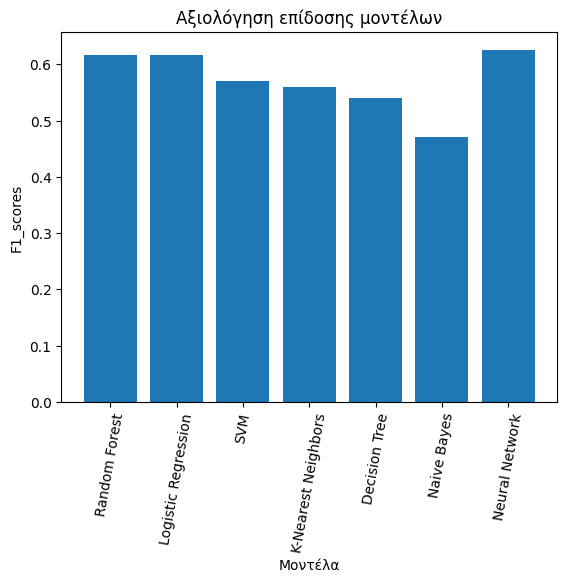

In [ ]:
F1_scores=[]
models=[]

for classifier_name,Y_predict in predictions.items():

  F1_scores.append(f1_score(Y_val,Y_predict))
  models.append(classifier_name)

plt.bar(models,F1_scores)
plt.xlabel('Μοντέλα')
plt.ylabel('F1_scores')
plt.title('Αξιολόγηση επίδοσης μοντέλων')
plt.xticks(rotation=80)
plt.show()


Πριν κάνω προβλέψεις για το test_set θα το περάσω από το ίδιο preprocessing που έκανα και στο train_val set. Εδώ όμως δεν θα κάνω fit τον preprocessor στο test_set καθώς θέλω να χρησιμοποιήσω τις παραμέτρους που υπολόγισα από το train_val αφού βάση αυτού εκπαίδευσα το μοντέλο μου.

In [ ]:
test_set['Date'] = pd.to_datetime(test_set['Date'])

month = test_set['Date'].dt.month
day=test_set['Date'].dt.day
year=test_set['Date'].dt.year


test_set.drop('Date',axis=1,inplace=True)


test_set.insert(1,'Year',year)
test_set.insert(2,'Month',month)
test_set.insert(3,'Day',day)

In [ ]:
train_val_2=train_val.drop('RainTomorrow',axis=1)
test_set.drop(['MinTemp','Evaporation','WindSpeed9am','WindSpeed3pm','Temp9am','MaxTemp','MaxTemp','Pressure9am','Cloud9am','WindDir9am','WindGustDir'],axis=1,inplace=True)

In [ ]:
test_preprocessor=ColumnTransformer(transformers=[('num',numeric_transformer,numeric_features),('cat',categorical_transformer,categorical_features)],remainder='passthrough')
test_preprocessor.fit(train_val_2)


test_set_processed=test_preprocessor.transform(test_set)
test_set_processed=test_set_processed.toarray()

neural_network_test_pred=classifiers['Neural Network'].predict(test_set_processed)

###  Βελτιστοποίηση μοντέλων με εύρεση καλύτερων υπερπαραμέτρων των ταξινομητών

Βελτιστοποίηση υπερπαραμέτρων για τους 7 ταξινομητές με την χρήση grid-search

In [ ]:
best_parameters={}

classifier_grid={'Logistic Regression':(LogisticRegression(),      {'penalty':['l1','l2'],'solver':['saga'],'C':[0.01,0.1,1.0,10.0],'max_iter':[1000]}),

                 'Random Forest':      (RandomForestClassifier(class_weight='balanced'),  {'n_estimators':[100,200,400,600,800],'max_features':[30,45,62,77],'max_depth':[4,6,8,10],
                                                                                           'min_samples_split':[10,50,100,150,200,300,400],
                                                                                           'min_samples_leaf':[20,50,100],'criterion':['entropy']}),

                 'SVC':                (SVC(),                     {'kernel': ['rbf','linear','poly','sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [0.01,0.1,1,10]}),


                 'Kneighbors':         (KNeighborsClassifier(),    {'n_neighbors':[5,9,13,17,19,21,24],'metric':['euclidean','manhattan'],'weights':['uniform','distance']}),


                 'MLP':                (MLPClassifier(),           {'hidden_layer_sizes':[(16),(64),(32),(128)],'solver':['adam','lbfgs'],'alpha':[0.01,0.1,1.0,10.0],'activation':['relu','logistic','tanh']}),


                 'Decision Tree':      (DecisionTreeClassifier(class_weight='balanced'),  {'criterion':['gini','entropy'],'max_depth':[3,6,8,10],'min_samples_split':[10,70,140,200],
                                                                    'min_samples_leaf':[10,50,100,150]})
                 }


for classifier_name,(classifier,parameters) in classifier_grid.items():

    grid_search=GridSearchCV(classifier,parameters,verbose=2,n_jobs=-1,scoring='f1')
    grid_search.fit(X_train,Y_train)
    best_parameters[classifier_name]=grid_search.best_params_





Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Naethiell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 1260 candidates, totalling 6300 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
best_parameters

{'Logistic Regression': {'C': 10.0,
  'max_iter': 1000,
  'penalty': 'l1',
  'solver': 'saga'},
 'Random Forest': {'criterion': 'entropy',
  'max_depth': 10,
  'max_features': 62,
  'min_samples_leaf': 20,
  'min_samples_split': 10,
  'n_estimators': 200},
 'SVC': {'C': 10, 'gamma': 0.001, 'kernel': 'linear'},
 'Kneighbors': {'metric': 'manhattan',
  'n_neighbors': 5,
  'weights': 'distance'},
 'MLP': {'activation': 'relu',
  'alpha': 0.1,
  'hidden_layer_sizes': 128,
  'solver': 'adam'},
 'Decision Tree': {'criterion': 'gini',
  'max_depth': 8,
  'min_samples_leaf': 100,
  'min_samples_split': 10}}

In [ ]:
classifiers_tuned = {
     'Random Forest': RandomForestClassifier(criterion= 'entropy',max_depth= 10,max_features=77, min_samples_leaf= 20,min_samples_split= 10, n_estimators= 200),
     'Logistic Regression': LogisticRegression(C= 10.0, max_iter= 1000, penalty= 'l1', solver= 'saga'),
     'SVC': SVC(C= 10, gamma= 0.001, kernel= 'linear'),
     'K-Nearest Neighbors': KNeighborsClassifier(metric= 'manhattan', n_neighbors= 5,weights = 'distance'),
     'Decision Tree': DecisionTreeClassifier(criterion= 'gini',max_depth= 8,min_samples_leaf= 100, min_samples_split=10),
     'Naive Bayes': GaussianNB(),
     'Neural Network': MLPClassifier(activation= 'relu',alpha= 0.1,hidden_layer_sizes= 128, solver= 'adam')}


for name, classifier in classifiers_tuned.items():
    classifier.fit(X_train,Y_train)

C:\Users\Naethiell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
predictions_tuned={}
for name,classifier in classifiers_tuned.items():
    predictions_tuned[name]=classifier.predict(X_val)

In [ ]:
for classifier_name,Y_predict in predictions_tuned.items():
  report=classification_report(Y_val,Y_predict)
  print(f'classification report for classifier "{classifier_name}" is: \n{report}')
  print(f1_score(Y_val,Y_predict))

classification report for classifier "Random Forest" is: 
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     11184
         1.0       0.76      0.52      0.62      3343

    accuracy                           0.85     14527
   macro avg       0.82      0.74      0.76     14527
weighted avg       0.85      0.85      0.84     14527

0.6211180124223603
classification report for classifier "Logistic Regression" is: 
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91     11184
         1.0       0.74      0.52      0.61      3343

    accuracy                           0.85     14527
   macro avg       0.80      0.73      0.76     14527
weighted avg       0.84      0.85      0.84     14527

0.612937062937063
classification report for classifier "SVC" is: 
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     11184
         1.0       0.76      0


Την καλύτερη επίδοση  έχει  το MLP. Στους υπόλοιπους classifiers δεν βλέπουμε σημαντικές βελτιώσεις.

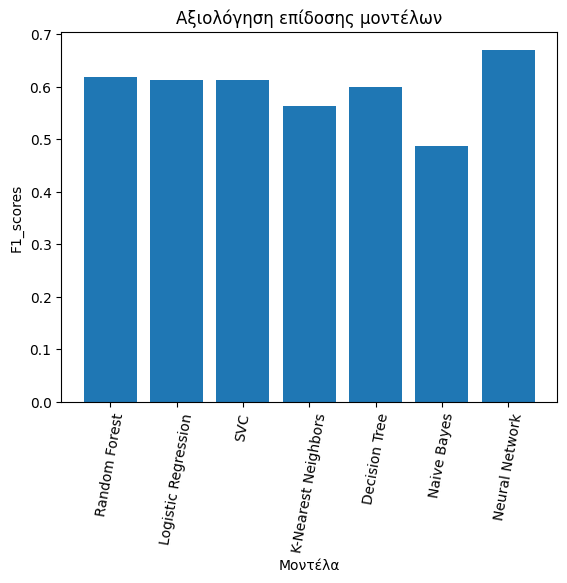

In [ ]:
F1_scores_tuned=[]
models_tuned=[]

for classifier_name,Y_predict in predictions_tuned.items():

  F1_scores_tuned.append(f1_score(Y_val,Y_predict))
  models_tuned.append(classifier_name)

plt.bar(models_tuned,F1_scores_tuned)
plt.xlabel('Μοντέλα')
plt.ylabel('F1_scores')
plt.title('Αξιολόγηση επίδοσης μοντέλων')
plt.xticks(rotation=80)
plt.show()

In [ ]:
best_model=classifiers_tuned['Neural Network']